# Water Balance for Canopy-enabled simulations

This sheet checks and documents the water balance for ATS simulations based on models such as "priestly_taylor_canopy_evapotranspiration" that include four water pools -- canopy, snow, surface water, and subsurface water.  We can verify each of these independently.

Note all of these are done in units of [m] or [m/s], which means dividing by surface area or molar density as required to convert to these units.


In [1]:
#dirname = 'priestley_taylor_canopy_evapotranspiration_relperm_trf.demo'
dirname = 'priestley_taylor_canopy_evapotranspiration_relperm_trf_surftemp.demo'
cv_key = 'canopy-cell_volume'

In [2]:
import h5py
import pandas
import numpy as np
from matplotlib import pyplot as plt
import sys, os

In [3]:
with h5py.File(os.path.join(dirname, 'ats_vis_surface_data.h5'),'r') as d:
    a_key = list(d[cv_key].keys())[0]
    surf_area = d[cv_key][a_key][:].sum() # m^2

In [4]:
# load data
df = pandas.read_csv(os.path.join(dirname, 'water_balance.dat'), comment='#')
time = df['time [d]']


## Global water balance
First look at the global balance.  The global balance is given by:

dWC/dt = P + S - ET - Q

where:

- WC: total global water content (converted from mol --> m)
- P: precip of rain
- S: precip of snow
- ET: total evapotranspiration across all four pools (canopy evaporation, snow sublimation/condensation, surface water evaporation, and transpiration)
- Q: surface water runoff

In [5]:
# process -- global water balance -- converting all to m/day
gf = dict()
gf['P'] = df['rain precipitation [m d^-1]']
gf['S'] = df['snow precipitation [m d^-1]']
gf['ET'] = df['evapotranspiration [m d^-1]']
gf['Q'] = df['runoff generation [mol d^-1]']/55500./surf_area
gf_net = gf['P'] + gf['S'] - gf['ET'] - gf['Q']
global_water = (df['canopy water content [mol]'] + df['snow water content [mol]'] + df['surface water content [mol]'] + df['subsurface water content [mol]']) / 55500 / surf_area


In [6]:
def plot(name, time, fluxes, water, net_fluxes):
    # compute error
    error = np.cumsum(net_fluxes) - (water - water[0])
    max_error = error.max()    
    
    # plot
    fig = plt.figure(figsize=(14,12))

    # two plots -- first is cumulative fluxes
    ax = fig.add_subplot(2,1,1)
    for k,v in fluxes.items():
        ax.plot(time, np.cumsum(v), label=k)

    ax.plot(time, water - water[0], 'k', label='water')
    ax.plot(time, np.cumsum(net_fluxes), 'k--', label='net fluxes')
    ax.plot(time, error, '-.', color='grey', label='error')
    ax.legend()

    ax.set_title(f'{name}: cumulative sums of fluxes (Inf err: {max_error})')
    ax.set_xlabel('time [d]')
    ax.set_ylabel('cumulative flux [m]')

    # two plots -- second is gross fluxes
    ax = fig.add_subplot(2,1,2)
    for k,v in fluxes.items():
        ax.plot(time, v, label=k)
    ax.plot(time, error[1:] - error[:-1], '-.', color='grey', label='delta error')
    ax.legend()
    ax.set_title(f'{name}: fluxes')
    ax.set_xlabel('time [d]')
    ax.set_ylabel('flux [m / d]')
    


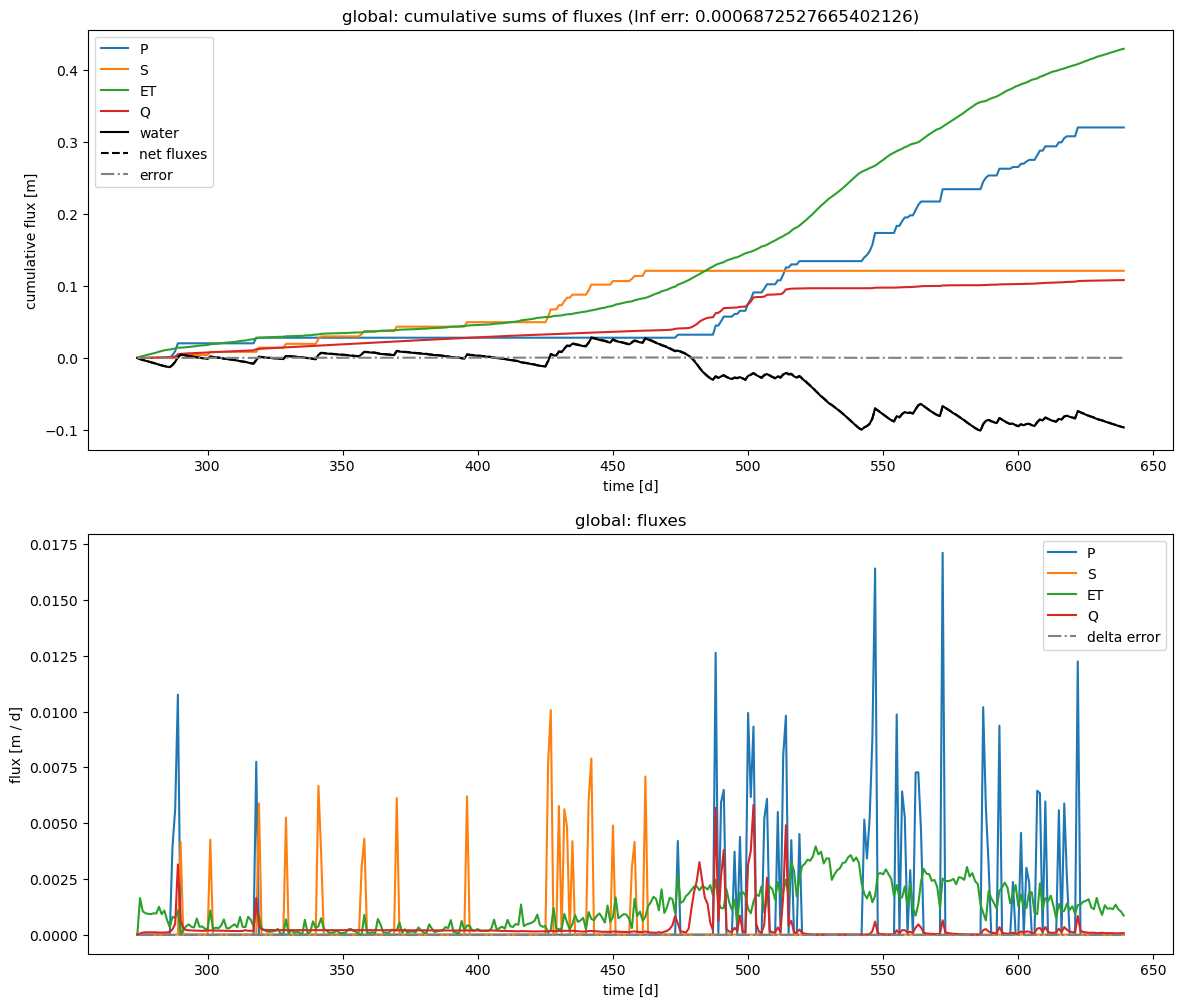

In [7]:
# plot the global water balance:
plot('global', time, gf, global_water, gf_net)

## Snow water balance

Next lets verify each individual component.  First we look at snow.

Snow mass balance is given by:

dWC_snow/dt = S_throughfall + S_drippage - ET_snow - SM

where:

- WC_snow: snow water content
- S_throughfall: portion of snow precip that misses the canopy and lands on the snowpack
- S_drippage: portion of snow that drops from the canopy
- ET: snow sublimation (positive) or condensation (negative)
- SM: snow melt

In [8]:
# process -- snow water balance -- converting all to m/day
snowf = dict()
snowf['TF+D'] = df['snow throughfall + canopy drainage [m d^-1]']
snowf['ET'] = df['snow evaporation [m d^-1]']
snowf['SM'] = df['snowmelt [m d^-1]']

snowf_net = snowf['TF+D'] - snowf['ET'] - snowf['SM']
snow_water = df['snow water content [mol]'] / 55500 / surf_area

Note that, in this run, snow evaporation keeps up with snowfall, so there is never a snowpack!  This is a problem in the data or in the parameters, and needs to be checked.  Although there is very little snow (2cm) in total in this forcing dataset, so maybe this isn't actually a big problem.

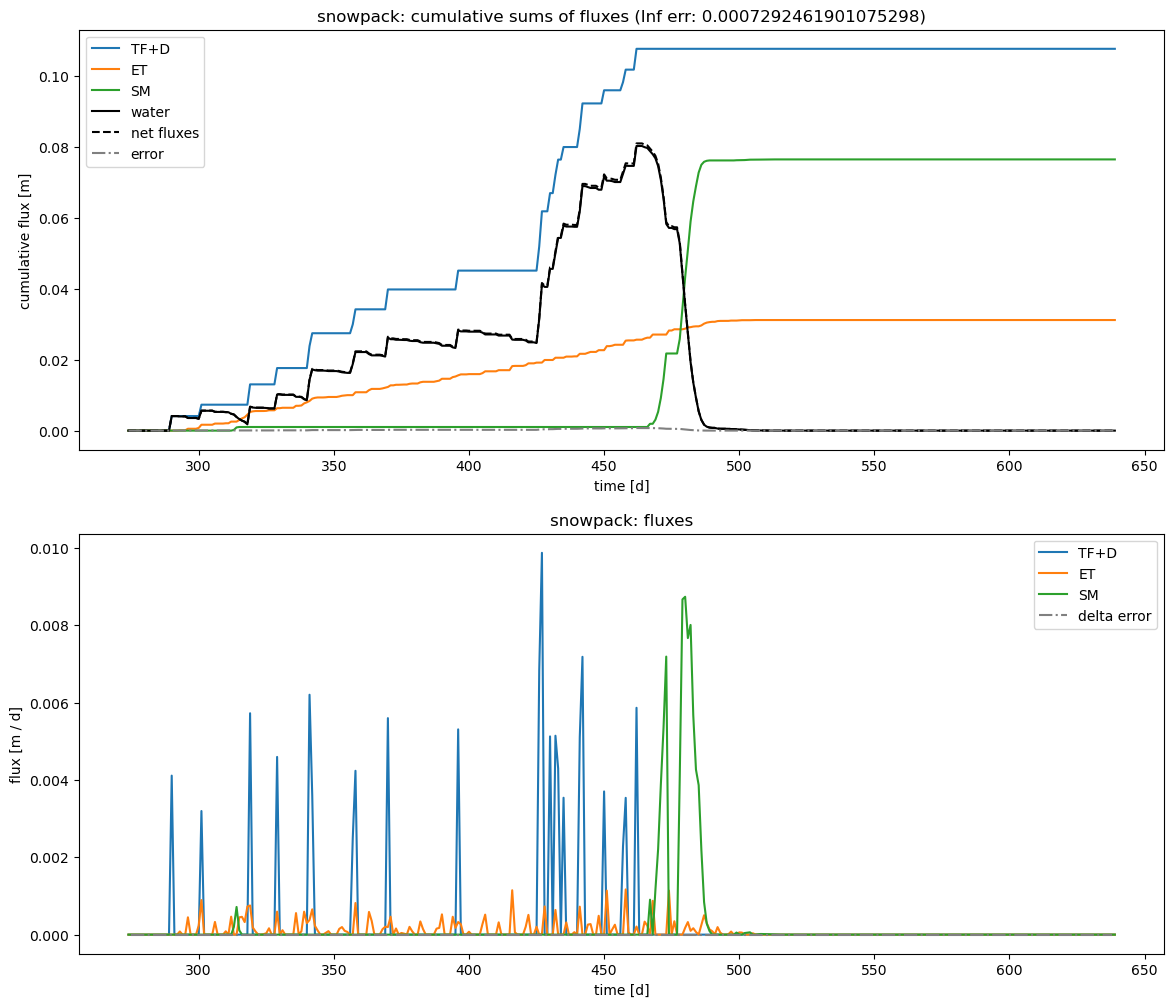

In [9]:
plot('snowpack', time, snowf, snow_water, snowf_net)

## Canopy water balance

dWC_can/dt = S_interception + P_interception - D - ET_can

where:

- WC_can: canopy water content
- I: interception of rain and snow
- D: drainage and dripping from the canopy
- ET: leaf canopy water evaporation


In [10]:
# process -- canopy water balance -- converting all to m/day
canf = dict()
canf['I'] = df['canopy interception [m d^-1]']
canf['D'] = df['canopy drainage [m d^-1]']
#canf['ET'] = df['canopy evaporation [m d^-1]']

canf_net = canf['I'] - canf['D'] #- canf['ET']
can_water = df['canopy water content [mol]'] / 55500 / surf_area

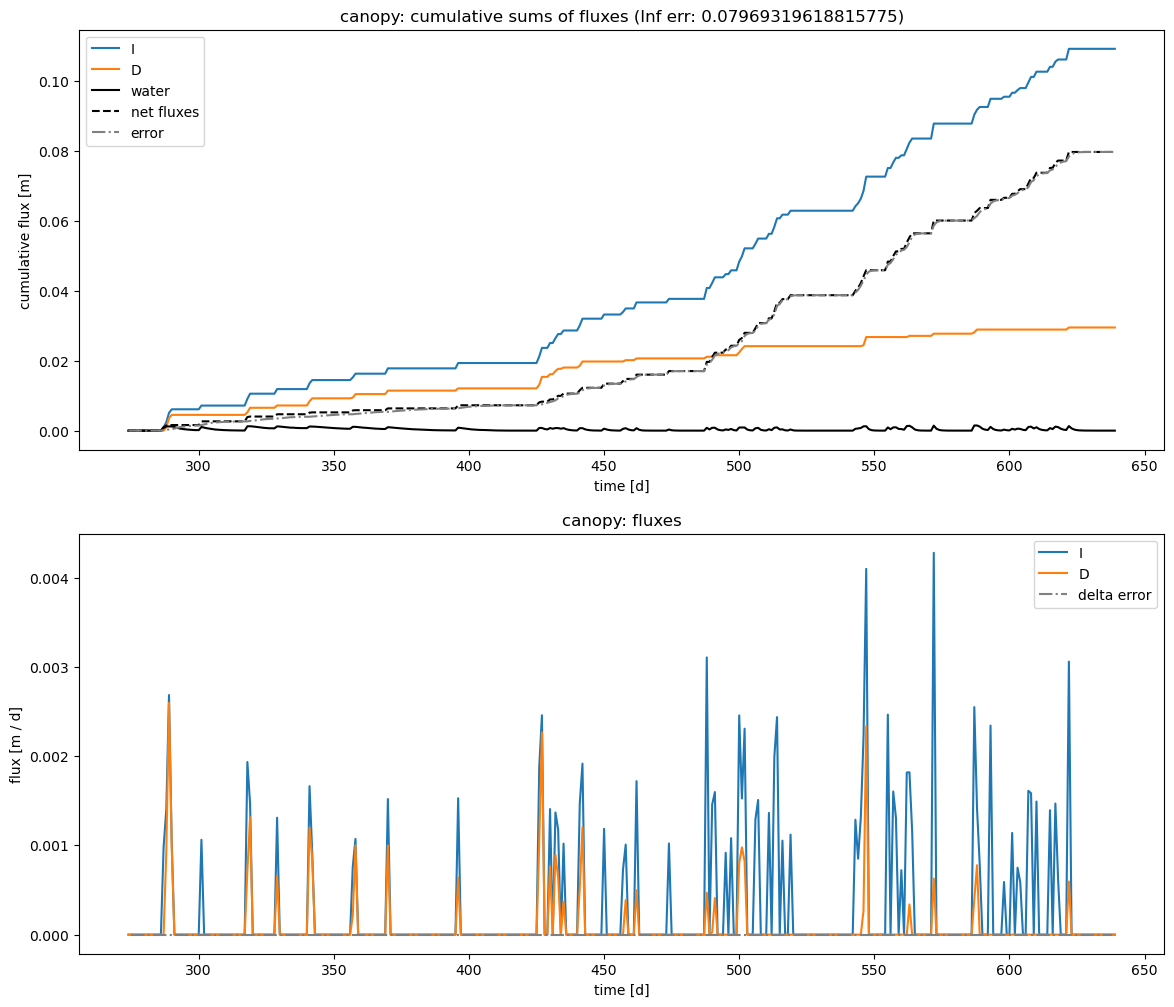

In [11]:
plot('canopy', time, canf, can_water, canf_net)

## Surface water balance

dWC_surf/dt = P_throughfall + D_rain + SM - ET - Q - I

where:

- WC_surf: surface water content
- P_throughfall: throughfall of rain
- D_rain: canopy drainage of rain
- SM: snowmelt
- E: surface water/bare ground evaporation
- Q: runoff/discharge (converted to m/s)
- I: infiltration


In [12]:
# process -- surface water balance -- converting all to m/day
surff = dict()
surff['TF+D'] = df['water throughfall + canopy drainage [m d^-1]']
surff['SM'] = df['snowmelt [m d^-1]']
surff['ET'] = df['surface evaporation [m d^-1]']
surff['Q'] = df['runoff generation [mol d^-1]'] / 55500. / surf_area
surff['I'] = -df['exfiltration [mol d^-1]'] / 55000. / surf_area

surff_net = surff['TF+D'] + surff['SM'] - surff['ET'] - surff['Q'] - surff['I']
surf_water = df['surface water content [mol]'] / 55500 / surf_area

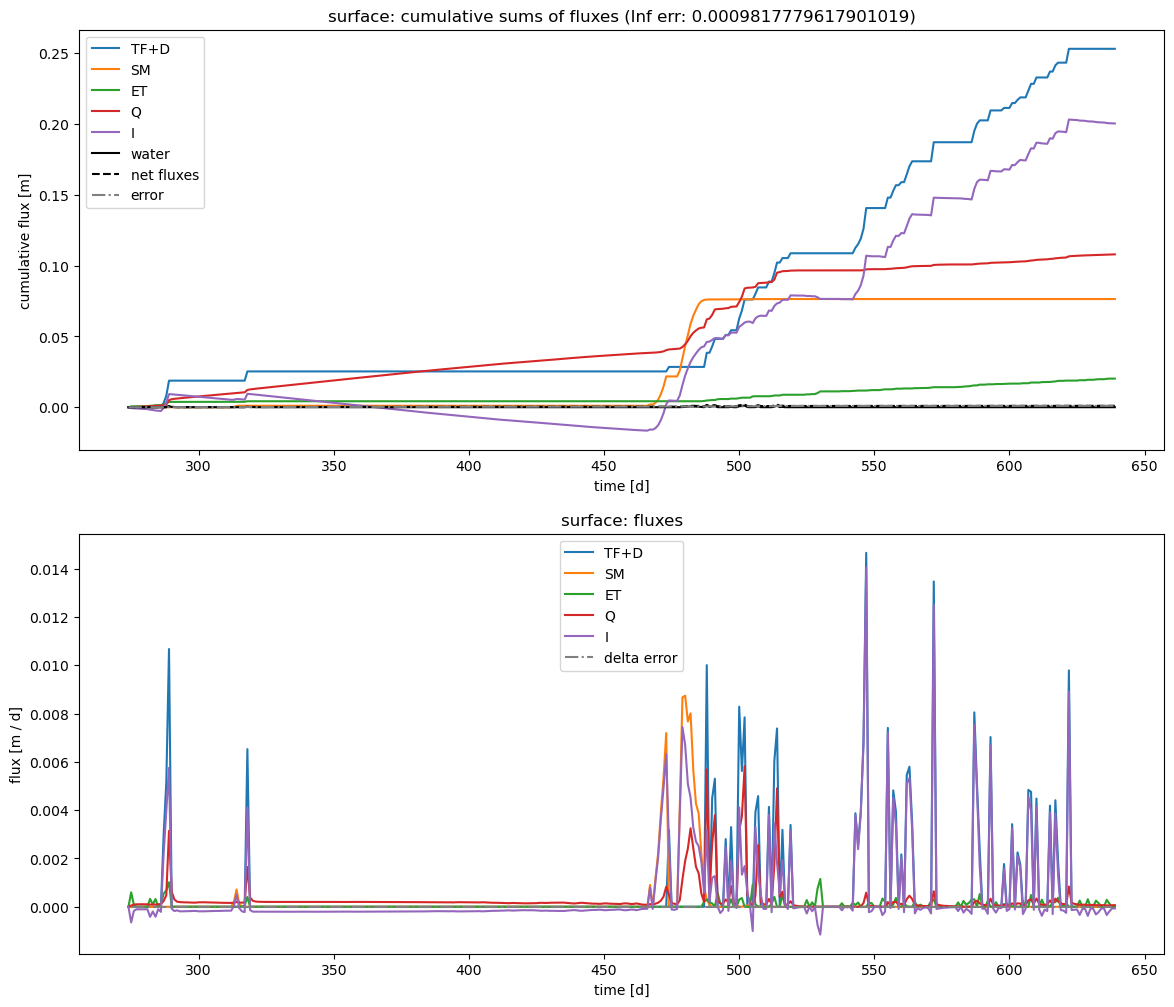

In [13]:
plot('surface', time, surff, surf_water, surff_net)

## Subsurface water balance

Lastly the subsurface is fairly simple because we closed all the boundaries except the surface:

dWC/dt = I - T

Where:

- WC: subsurface water content
- I: infiltration
- T: transpiration



In [14]:
# process -- surface water balance -- converting all to m/day
subf = dict()
subf['ET'] = df['transpiration [m d^-1]']
subf['I'] = -df['exfiltration [mol d^-1]'] / 55000. / surf_area

subf_net = subf['I'] - subf['ET']
sub_water = df['subsurface water content [mol]'] / 55500 / surf_area

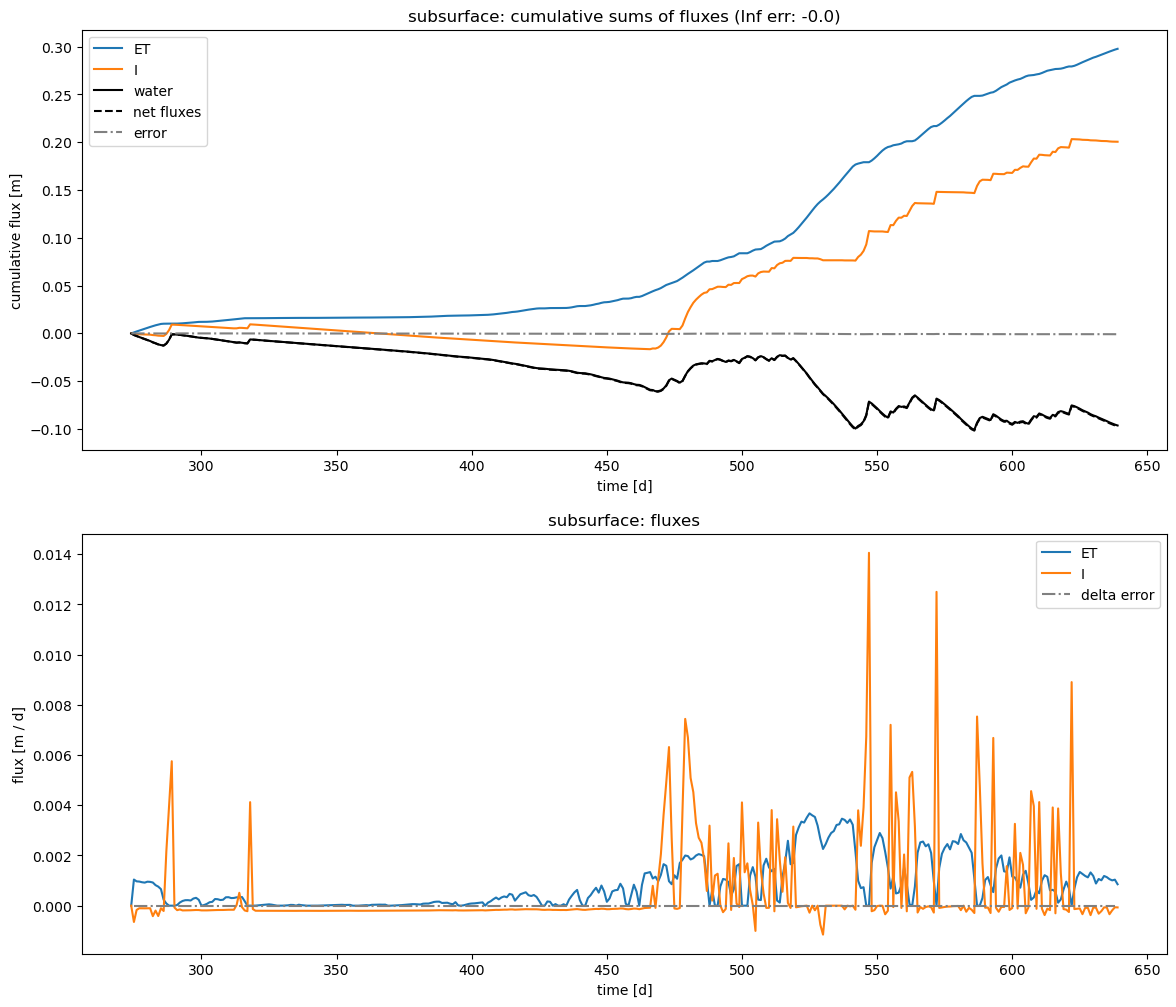

In [15]:
plot('subsurface', time, subf, sub_water, subf_net)

## Consistency and assumptions

Lastly, we just check a few assumptions to make sure we didn't get things wrong in the input file.

First, check that the precip is correctly allocated:

P + S = I + T

Because we lump drainage and throughfall, we have to compute:

P + S - I - (TF+D_water + TF+D_snow - D) = 0



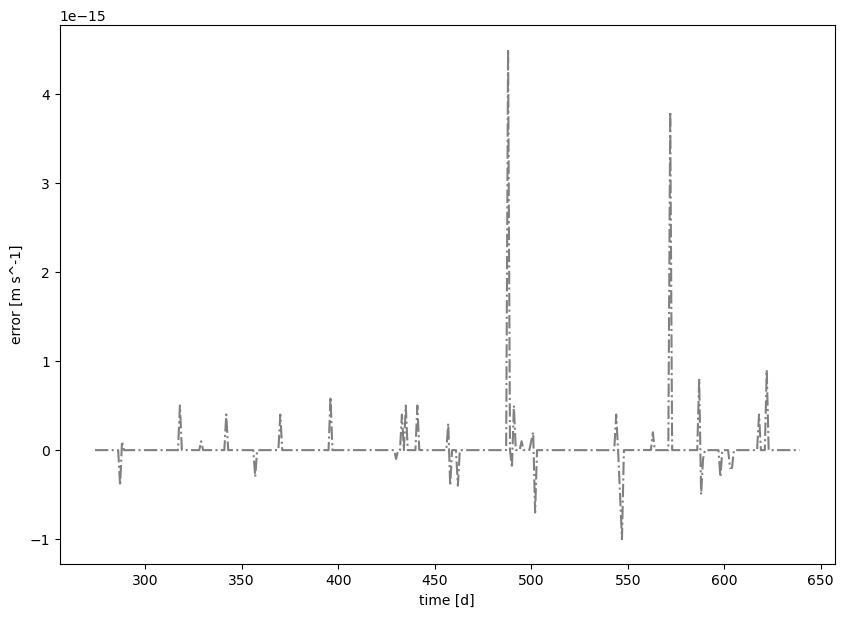

In [16]:
error = gf['P'] + gf['S'] - canf['I'] - snowf['TF+D'] - surff['TF+D'] + canf['D']

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.plot(time, error, '-.', color='grey', label='error in rain/snow allocation')
ax.set_xlabel('time [d]')
ax.set_ylabel('error [m s^-1]')
plt.show()
